![digitizing_team](image.png)


DigiNsure Inc. is an innovative insurance company focused on enhancing the efficiency of processing claims and customer service interactions. Their newest initiative is digitizing all historical insurance claim documents, which includes improving the labeling of some IDs scanned from paper documents and identifying them as primary or secondary IDs.

To help them in their effort, you'll be using multi-modal learning to train an Optical Character Recognition (OCR) model. To improve the classification, the model will use **images** of the scanned documents as input and their **insurance type** (home, life, auto, health, or other). Integrating different data modalities (such as image and text) enables the model to perform better in complex scenarios, helping to capture more nuanced information. The **labels** that the model will be trained to identify are of two types: a primary and a secondary ID, for each image-insurance type pair.

In [5]:
! pip install -r requirements.txt

  Using cached matplotlib-3.7.5-cp38-cp38-macosx_10_12_x86_64.whl.metadata (5.7 kB)
ERROR: Ignored the following versions that require a different python version: 3.8.0 Requires-Python >=3.9; 3.8.0rc1 Requires-Python >=3.9; 3.8.1 Requires-Python >=3.9; 3.8.2 Requires-Python >=3.9; 3.8.3 Requires-Python >=3.9; 3.8.4 Requires-Python >=3.9; 3.9.0 Requires-Python >=3.9; 3.9.0rc2 Requires-Python >=3.9; 3.9.1 Requires-Python >=3.9
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [7]:
# Imprt the nessary libraries
import matplotlib.pyplot as plt
import numpy as np
from project_utils import ProjectDataset
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [10]:
# Load the data
dataset = pickle.load(open('ocr_insurance_dataset.pkl', 'rb'))


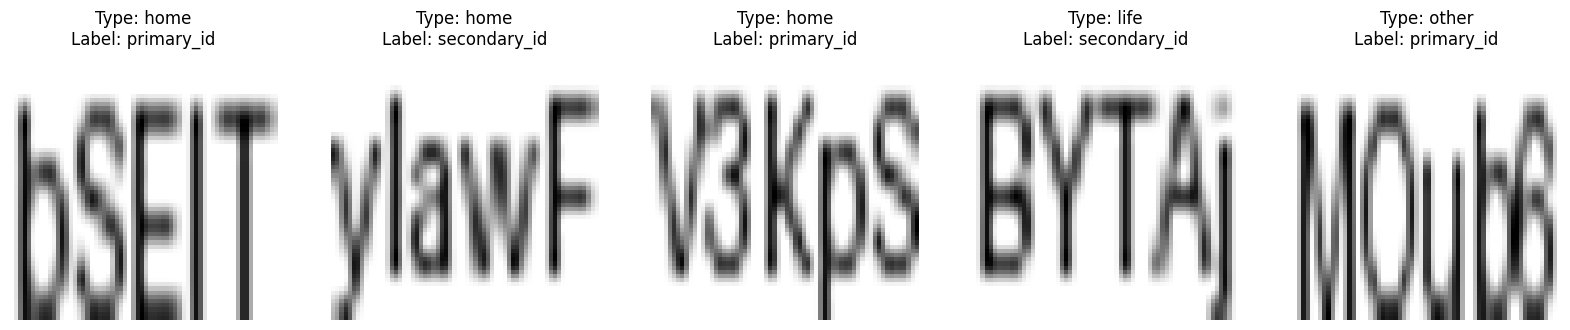

In [11]:
# Define a function to visualize codes with their corresponding types and labels 
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset), min(num_images, len(dataset)), False)):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray'), ax.axis('off')
        ax.set_title(f"Type: {list(dataset.type_mapping.keys())[img[1].tolist().index(1)]}\nLabel: {list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]}")
    plt.show()

# Inspect 5 codes images from the dataset
show_dataset_images(dataset)